In [1]:
# imports
import quail
import pliers
import numpy as np
import pandas as pd
import hypertools as hyp
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import resample
from scipy.stats import pearsonr as corr
import wikipedia
import wikia

%matplotlib inline
sns.set_context('poster')
plt.rc('figure', figsize=(12, 8))

In [4]:
# load sherlock dataset, drop extraneous info
movie_text = pd.read_excel('../../../sherlock_behavioral_data/Sherlock_Segments_1000_NN_2017.xlsx')
movie_text['Scene Segments'].fillna(method='ffill', inplace=True)
movie_text = movie_text[movie_text['Segment Number']>7]
movie_text = movie_text.reset_index(drop=True)
movie_text['Segment Number'] = pd.RangeIndex(len(movie_text.index))

## Model movie from hand annotations

In [194]:
def get_movie_model(movie):

    # create a list of overlapping text samples
    movie50 = []
    wsize=50
    for idx, sentence in enumerate(movie):
        movie50.append(','.join(movie[idx:idx+wsize]))

    # vectorizer parameters
    vectorizer = {
        'model' : 'CountVectorizer', 
        'params' : {
            'stop_words' : 'english'
        }
    }

    # topic model parameters
    semantic = {
        'model' : 'LatentDirichletAllocation', 
        'params' : {
            'n_components' : 100,
            'learning_method' : 'batch',
            'random_state' : 0
        }
    }

    # create movie model with hypertools
    movie_model = hyp.tools.format_data(movie50, vectorizer=vectorizer, semantic=semantic, corpus=movie50)[0]

    # description are by scene, not TR so stretch the model to be in TRs
    ranges =[[d['Start Time (TRs, 1.5s)'],d['End Time (TRs, 1.5s)']] for i, d in movie_text.iterrows()] 
    expanded = []
    for i in range(1976):
        try:
            idx = np.where([i>=r[0] and i<=r[1] for r in ranges])[0][0]
            expanded.append(movie_model[idx, :])
        except:
            expanded.append(movie_model[0, :])
    return np.array(expanded)

# create a list of text samples from the scene descriptions / details to train the topic model
movie = movie_text.loc[:,'Scene Details - A Level ':'Words on Screen '].apply(lambda x: ', '.join(x.fillna('')), axis=1).values.tolist()

movie_model = get_movie_model(movie)

## What features are most important to model?

In [197]:
#find way to replace "'\'s" with "'s"?
features = sherlock_text.loc[:,'Scene Details - A Level ':'Words on Screen ']
dists = {}
for feat in features.columns:
    text_samples = features.drop(feat, axis=1).apply(lambda x: ','.join(x.fillna('')), axis=1).values.tolist()
    movie_dropone = get_movie_model(text_samples)
    dists[feat]= corr(pd.DataFrame(movie_model).T.corr().as_matrix().ravel(), pd.DataFrame(movie_dropone).T.corr().as_matrix().ravel())[0]
    print(feat)

Scene Details - A Level 
Space-In/Outdoor
Name - All
Name - Focus
Name - Speaking
Location
Camera Angle
Music Presence 
Words on Screen 


Text(0.5,0,'Feature removed')

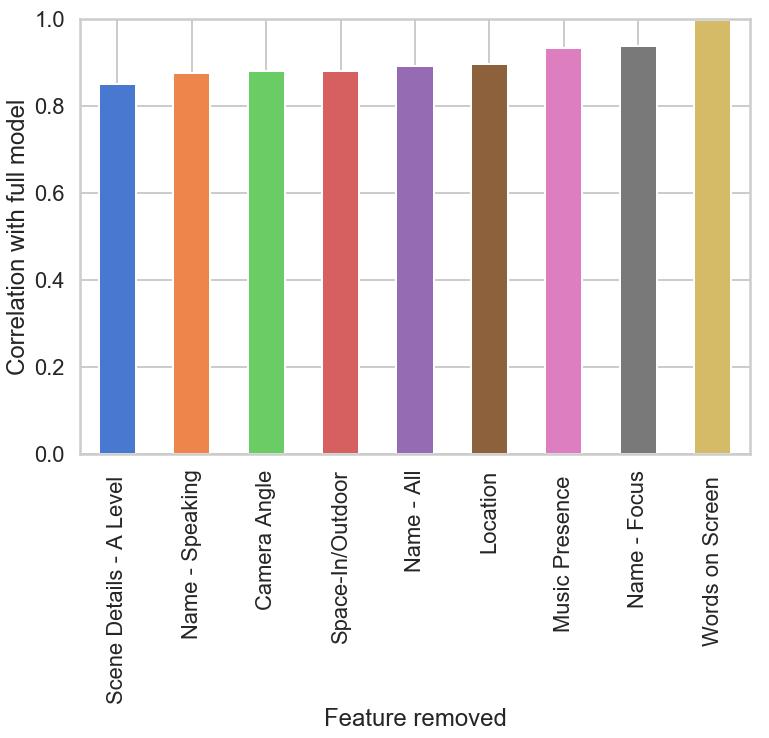

In [198]:
sns.set_palette('muted')
pd.Series(dists).sort_values().plot(kind='bar', ylim=[0, 1])
plt.ylabel('Correlation with full model')
plt.xlabel('Feature removed')

In [211]:
movie_text

,Segment Number,Start Time (s),End Time (s),"Start Time (TRs, 1.5s)","End Time (TRs, 1.5s)",Scene Segments,Scene Details - A Level,Space-In/Outdoor,Name - All,Name - Focus,...,Music Presence,Words on Screen,Arousal - Rater 1,Valence - Rater 1,Arousal - Rater 2,Valence - Rater 2,Arousal - Rater 3,Valence - Rater 3,Arousal - Rater 4,Valence - Rater 4
0,0,39,40,27.0,27.0,2. War Scene,Gunfire by a soldier along a wall made of stac...,Outdoor,Soldiers,Soldiers,...,No,NaN,5,-,5,-,4,-,2,-
1,1,40,41,28.0,28.0,2. War Scene,A bomb or land mine goes off in the middle of ...,Outdoor,Soldiers,Soldiers,...,No,NaN,5,-,5,-,5,-,2,-
2,2,41,42,28.0,28.0,2. War Scene,A Soldier kicks open a door. Soldiers shooting...,Outdoor,Soldiers,Soldiers,...,No,NaN,5,-,5,-,5,-,2,-
3,3,42,43,29.0,29.0,2. War Scene,Close up view of John tossing in bed while sle...,Indoor,John,John,...,No,NaN,5,-,5,-,5,-,2,-
4,4,43,45,30.0,30.0,2. War Scene,More gunfire. Two soldiers seen hand signallin...,Outdoor,Soldiers,Soldiers,...,No,NaN,5,-,5,-,5,-,2,-
5,5,45,45,31.0,31.0,2. War Scene,Sideways view of john sleeping at night,Indoor,John,John,...,No,NaN,5,-,5,-,5,-,3,-
6,6,45,46,31.0,31.0,2. War Scene,One of the soldiers that was signalling collap...,Outdoor,Soldiers,Soldiers,...,No,NaN,5,-,5,-,5,-,3,-
7,7,46,47,32.0,32.0,2. War Scene,A soldier runs across the batttlefield. Cut to...,Outdoor,Soldiers,Soldiers,...,No,NaN,5,-,5,-,5,-,3,-
8,8,47,48,32.0,32.0,2. War Scene,Quick shot of John's face in pain as he is lyi...,Outdoor,"John, Unknown Soldier",John,...,No,NaN,5,-,5,-,5,-,3,-
9,9,48,49,33.0,33.0,2. War Scene,Random gunfire by a soldier standing nearby an...,Outdoor,"John, Soldiers","John, Soldiers",...,No,NaN,5,-,5,-,5,-,3,-


## automatically model movie

In [ ]:
#put all the extracted features in here once done

In [ ]:
from pliers.extractors import GoogleVisionAPIFaceExtractor

ext = GoogleVisionAPIFaceExtractor()


## graveyard

In [167]:
# # similariy model subject recalls
# # loop over subjects
# recall5 = []
# wsize=10
# for sub in range(1, 18):
    
#     # load subject data
#     recall = pd.read_csv('../../sherlock_behavioral_data/NN'+str(sub)+' transcript.txt', header=None, sep='.', error_bad_lines=False, encoding='latin-1').values.tolist()[0][:-1]
    
#     rs = []  
#     # loop over sentences
#     for sentence in recall:
#         try:
#             s = sentence.encode('utf-8').strip()
#             rs.append(sentence)
#         except:
#             pass # skips over nans
    
#     # create overlapping windows of n sentences
#     sub_recall5 = []
#     for idx, sentence in enumerate(rs):
#         sub_recall5.append(','.join(rs[idx:idx+wsize]))
        
#     recall5.append(sub_recall5)
    
# # create recall models
# recall_models = hyp.tools.format_data(recall5, vectorizer=vectorizer, semantic=semantic, corpus=movie50)
    
# recall_models_rs = list(map(lambda x: resample(x, 1976), recall_models))

In [179]:
# # train model on episode's wikipedia page
# wiki_text = wikipedia.page('A_Study_in_Pink').content.split('==')[2].replace('\n','').split('.')
# wsize=5
# wiki_recall5 = []
# for idx, sentence in enumerate(wiki_text):
#     wiki_recall5.append(','.join(wiki_text[idx:idx+wsize]))
# wiki_model = hyp.tools.format_data(wiki_recall5, vectorizer=vectorizer, semantic=semantic, corpus=movie50)

In [ ]:
# #train model on episode's bakerstreet.wikia page
# wikia_text = wikia.page('bakerstreet','A_Study_in_Pink').content.replace('\n','').replace('\xa0',' ')[516:].split('.')
# wsize=12
# wikia_recall5 = []
# for idx, sentence in enumerate(wikia_text):
#     wikia_recall5.append(','.join(wikia_text[idx:idx+wsize]))
# wikia_model = hyp.tools.format_data(wikia_recall5, vectorizer=vectorizer, semantic=semantic, corpus=movie50)